In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
pwd

'C:\\Users\\vinot\\Fintech\\LSTM\\Bitcoin_Price_Prediction'

In [4]:
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [5]:
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [6]:
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [7]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
window_size = 1

# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [9]:
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)
X_train[:5]

array([[0.25287356],
       [0.08045977],
       [0.36781609],
       [0.18390805],
       [0.03448276]])

In [11]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.25287356]]

 [[0.08045977]]

 [[0.36781609]]

 [[0.18390805]]

 [[0.03448276]]] 

X_test sample values:
[[[0.40229885]]

 [[0.37931034]]

 [[0.34482759]]

 [[0.63218391]]

 [[0.65517241]]]


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [13]:
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [14]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 1, 30)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 30)             7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [16]:
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
377/377 [==============================] - 1s 2ms/step - loss: 0.0517
Epoch 2/10
377/377 [==============================] - 1s 2ms/step - loss: 0.0306
Epoch 3/10
377/377 [==============================] - 1s 2ms/step - loss: 0.0297
Epoch 4/10
377/377 [==============================] - 1s 2ms/step - loss: 0.0278
Epoch 5/10
377/377 [==============================] - 1s 2ms/step - loss: 0.0267
Epoch 6/10
377/377 [==============================] - 1s 2ms/step - loss: 0.0264
Epoch 7/10
377/377 [==============================] - 1s 2ms/step - loss: 0.0259
Epoch 8/10
377/377 [==============================] - 1s 2ms/step - loss: 0.0263
Epoch 9/10
377/377 [==============================] - 1s 2ms/step - loss: 0.0266
Epoch 10/10
377/377 [==============================] - 1s 2ms/step - loss: 0.0266


In [17]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 1ms/step - loss: 0.1098


0.10977328568696976

In [18]:
predicted = model.predict(X_test)

In [19]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stocks.head()

,Real,Predicted
0,3670.919922,4599.733887
1,3670.919922,4520.058105
2,3912.570068,4399.255859
3,3924.239990,5333.792480
4,3974.050049,5398.844727


<AxesSubplot:title={'center':'Real vs. Predicted Stock Price'}, xlabel='Days', ylabel='Price'>

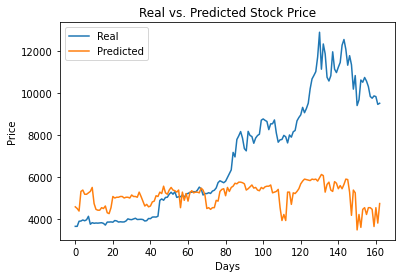

In [21]:
stocks.plot(title="Real vs. Predicted Stock Price", xlabel="Days", ylabel="Price")